In [1]:
!pip install mediapipe
!pip install  cvzone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 32.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0

In [2]:
import os
import pickle
import pandas as pd
import numpy as np

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

2025-04-17 12:11:08.573673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744891868.897010      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744891868.997768      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

I0000 00:00:1744822401.339474      31 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1744822401.391960     130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744822401.425414     130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


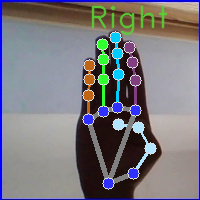

In [8]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='/kaggle/input/handlandmark/tensorflow2/default/1/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2,min_hand_detection_confidence=0.8)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

## Dataset

In [76]:
#
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from sklearn.preprocessing import MinMaxScaler

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='/kaggle/input/handlandmark/tensorflow2/default/1/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2,min_hand_detection_confidence=0.1)
detector = vision.HandLandmarker.create_from_options(options)

# Initialize and apply MinMaxScaler
scaler = MinMaxScaler()

x_lists = {f'x{i}': [] for i in range(42)}
y_lists = {f'y{i}': [] for i in range(42)}
z_lists = {f'z{i}': [] for i in range(42)}

label=[]

unwanted=["nothing",'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'] #removed the unwanted image folders
unwanted_path=["/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N2084.jpg",
               "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/M/M1434.jpg",
              "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/C/C689.jpg",
              "/kaggle/input/american-sign-language-dataset/asl_dataset/0/hand1_0_bot_seg_3_cropped.jpeg",
"/kaggle/input/american-sign-language-dataset/asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg",
"/kaggle/input/american-sign-language-dataset/asl_dataset/0/hand1_0_top_seg_3_cropped.jpeg",
"/kaggle/input/american-sign-language-dataset/asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg",
"/kaggle/input/american-sign-language-dataset/asl_dataset/0/hand1_0_bot_seg_2_cropped.jpeg",
"/kaggle/input/american-sign-language-dataset/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg",
              "/kaggle/input/american-sign-language-dataset/asl_dataset/1/hand5_1_bot_seg_5_cropped.jpeg",
              "/kaggle/input/american-sign-language-dataset/asl_dataset/6/hand1_6_left_seg_1_cropped.jpeg"]

root_folder="/kaggle/input/american-sign-language-dataset/asl_dataset"#"/kaggle/input/asl-words/words"#'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

for folder in os.listdir(root_folder):
    
    if folder.upper() not in unwanted:
      print(f"#########{folder}####################")
      t=1 
      for file in os.listdir(os.path.join(root_folder,folder)):
        if t<=500: #limit the images
              #print(os.path.join(root_folder,folder,file))
            image_path=os.path.join(root_folder,folder,file)
            file_name=image_path.split("/")[-1]
            if image_path not in unwanted_path:
                image = mp.Image.create_from_file(image_path)
    
                # Process the image to detect hand landmarks
                detection_result = detector.detect(image)
    
                if len(detection_result. hand_landmarks) !=0:
                  t += 1
                  
                  if len(detection_result. hand_landmarks) ==2:
                    label.append(folder.upper())
                    print(image_path)
                    for i in range(len(detection_result. hand_landmarks)):
                        
                      #print(detection_result.handedness[i][0].category_name)
                      # Original coordinates
                      x_coordinates = (np.array([landmark.x for landmark in detection_result.hand_landmarks[i]])).reshape(-1, 1)
                      y_coordinates = (np.array([landmark.y for landmark in detection_result.hand_landmarks[i]])).reshape(-1, 1)
                      z_coordinates = (np.array([landmark.z for landmark in detection_result.hand_landmarks[i]])).reshape(-1, 1)
                
                
                      scaled_x_coordinates = scaler.fit_transform(x_coordinates).flatten().tolist()
                      scaled_y_coordinates = scaler.fit_transform(y_coordinates).flatten().tolist()
                      scaled_z_coordinates = scaler.fit_transform(z_coordinates).flatten().tolist()
            
                
                
                      if detection_result.handedness[i][0].category_name =="Right":
                        for idx, (x, y, z) in enumerate(zip(scaled_x_coordinates, scaled_y_coordinates, scaled_z_coordinates)):
                          x_lists[f'x{idx}'].append(x)
                          y_lists[f'y{idx}'].append(y)
                          z_lists[f'z{idx}'].append(z)
                
                      elif detection_result.handedness[i][0].category_name =="Left":
                        for idx, (x, y, z) in enumerate(zip(scaled_x_coordinates, scaled_y_coordinates, scaled_z_coordinates)):
                          x_lists[f'x{21+idx}'].append(x)  # Shift by 21 for right hand
                          y_lists[f'y{21+idx}'].append(y)
                          z_lists[f'z{21+idx}'].append(z)
                            
                    
                
                  elif len(detection_result. hand_landmarks) ==1:
                      label.append(folder.upper())
                      
                      x_coordinates = (np.array([landmark.x for landmark in detection_result.hand_landmarks[0]])).reshape(-1, 1)
                      y_coordinates = (np.array([landmark.y for landmark in detection_result.hand_landmarks[0]])).reshape(-1, 1)
                      z_coordinates = (np.array([landmark.z for landmark in detection_result.hand_landmarks[0]])).reshape(-1, 1)
                
                      scaled_x_coordinates = scaler.fit_transform(x_coordinates).flatten().tolist()
                      scaled_y_coordinates = scaler.fit_transform(y_coordinates).flatten().tolist()
                      scaled_z_coordinates = scaler.fit_transform(z_coordinates).flatten().tolist()
                
                      #print(len(scaled_x_coordinates))
                      #print(scaled_y_coordinates)
                      #print(scaled_z_coordinates)
                      
                      if detection_result.handedness[0][0].category_name =="Right":
                        for idx, (x, y, z) in enumerate(zip(scaled_x_coordinates, scaled_y_coordinates, scaled_z_coordinates)):
                          x_lists[f'x{idx}'].append(x)
                          y_lists[f'y{idx}'].append(y)
                          z_lists[f'z{idx}'].append(z)
                
                        for idx, (x, y, z) in enumerate(zip(np.zeros(21),np.zeros(21), np.zeros(21))):
                          x_lists[f'x{21+idx}'].append(x)  # Shift by 21 for right hand
                          y_lists[f'y{21+idx}'].append(y)
                          z_lists[f'z{21+idx}'].append(z)
                            
                
                      elif detection_result.handedness[0][0].category_name =="Left":
                
                        for idx, (x, y, z) in enumerate(zip(np.zeros(21), np.zeros(21),np.zeros(21))):
                          x_lists[f'x{idx}'].append(x)
                          y_lists[f'y{idx}'].append(y)
                          z_lists[f'z{idx}'].append(z)
                          
                        for idx, (x, y, z) in enumerate(zip(scaled_x_coordinates, scaled_y_coordinates, scaled_z_coordinates)):
                          x_lists[f'x{21+idx}'].append(x)  # Shift by 21 for right hand
                          y_lists[f'y{21+idx}'].append(y)
                          z_lists[f'z{21+idx}'].append(z)
                            
                        
                
                
                else:
                  pass
                  #print("no detection land marks")
                

            

              
                        
    series = pd.Series(label)
    count = series.value_counts()
    print("count of collected data :", count)


I0000 00:00:1744830676.952180      31 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1744830677.000271     260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744830677.034477     260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


count of collected data : Series([], Name: count, dtype: int64)
#########7####################
count of collected data : 7    67
Name: count, dtype: int64
count of collected data : 7    67
Name: count, dtype: int64
#########2####################
count of collected data : 7    67
2    65
Name: count, dtype: int64
count of collected data : 7    67
2    65
Name: count, dtype: int64
count of collected data : 7    67
2    65
Name: count, dtype: int64
count of collected data : 7    67
2    65
Name: count, dtype: int64
count of collected data : 7    67
2    65
Name: count, dtype: int64
#########5####################
count of collected data : 5    70
7    67
2    65
Name: count, dtype: int64
count of collected data : 5    70
7    67
2    65
Name: count, dtype: int64
count of collected data : 5    70
7    67
2    65
Name: count, dtype: int64
count of collected data : 5    70
7    67
2    65
Name: count, dtype: int64
#########8####################
count of collected data : 5    70
7    67
8    6

In [77]:

len(y_lists["y2"])

650

In [78]:

len(label)

650

In [79]:


import pandas as pd

df_y=pd.DataFrame(y_lists)
df_x=pd.DataFrame(x_lists)
df_z=pd.DataFrame(z_lists)
df_label=pd.DataFrame(label)

df=pd.concat([df_x,df_y,df_z,df_label],axis=1)

In [80]:
set(label)

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [81]:
df.info


<bound method DataFrame.info of            x0        x1        x2        x3        x4        x5        x6  \
0    0.512955  0.707905  0.813430  0.709620  0.547071  0.827420  0.926294   
1    0.715143  0.896590  1.000000  0.916001  0.757485  0.846903  0.873125   
2    0.650741  0.903566  1.000000  0.816538  0.552449  0.861905  0.922647   
3    0.540720  0.841184  1.000000  0.832651  0.559173  0.802444  0.879723   
4    0.577401  0.813972  0.901610  0.744122  0.529969  0.876130  0.952120   
..        ...       ...       ...       ...       ...       ...       ...   
645  0.583514  0.869702  0.966251  0.694027  0.381426  0.796265  0.905544   
646  0.405783  0.737056  0.853235  0.527832  0.117252  0.831888  0.934553   
647  0.482666  0.856535  1.000000  0.669805  0.311406  0.834379  0.922387   
648  0.456238  0.818752  0.937988  0.626483  0.262121  0.828650  0.917717   
649  0.544514  0.765380  0.777946  0.400071  0.081718  0.806502  0.913588   

           x7        x8        x9  ...  z33

In [82]:

df.to_csv("american-sign-language_number.csv",index=False)